In [34]:
%%writefile train.py
# Train.py

Overwriting train.py


In [35]:
%%writefile -a train.py
# example of extracting bounding boxes from an annotation file
from xml.etree import ElementTree

Appending to train.py


In [36]:
%%writefile -a train.py

# function to extract bounding boxes from an annotation file
def extract_boxes(filename):
    # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = list()
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height

Appending to train.py


In [37]:
# extract details form annotation file
boxes, w, h = extract_boxes('dataset/training/annotations/image1.xml')
# summarize extracted details
print(boxes, w, h)

[[470, 971, 1052, 1666], [1252, 710, 1948, 1536], [2043, 562, 2800, 1375], [535, 1792, 1178, 2549], [1317, 1631, 2000, 2431], [2096, 1475, 2926, 2336]] 4032 3024


In [38]:
%%writefile -a train.py

# split into train and test set
from os import listdir
from numpy import zeros
from numpy import asarray

from mrcnn.utils import Dataset

# class that defines and loads the kangaroo dataset
class CustomDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "tokens")
        # define data locations
        images_dir = dataset_dir + 'images/'
        annotations_dir = dataset_dir + 'annotations/'
        # find all images
        for filename in listdir(images_dir):
            if not is_train:
                continue
            # extract image id
            image_id = filename[:-4]
            print(image_id)
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', 
                           image_id=image_id, 
                           path=img_path, 
                           annotation=ann_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('tokens'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

Appending to train.py


In [39]:
%%writefile -a train.py

# train set
train_set = CustomDataset()
train_set.load_dataset('./dataset/training/', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = CustomDataset()
test_set.load_dataset('./dataset/test/', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Appending to train.py


In [40]:
# load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)

(3024, 4032, 3)


In [41]:
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

(3024, 4032, 6)


In [42]:
from matplotlib import pyplot

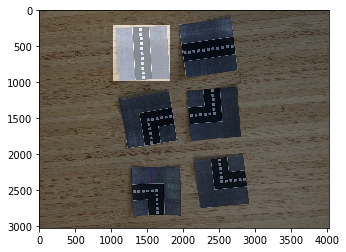

In [43]:
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

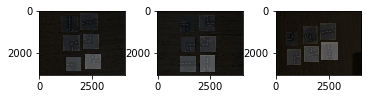

In [44]:
for i in range(3):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	image = train_set.load_image(i)
	pyplot.imshow(image)
	# plot all masks
	mask, _ = train_set.load_mask(i)
	for j in range(mask.shape[2]):
		pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
pyplot.show()

In [45]:
# enumerate all images in the dataset
for image_id in train_set.image_ids:
	# load image info
	info = train_set.image_info[image_id]
	# display on the console
	print(info)

{'id': 'image4', 'source': 'dataset', 'path': './dataset/training/images/image4.jpg', 'annotation': './dataset/training/annotations/image4.xml'}
{'id': 'image5', 'source': 'dataset', 'path': './dataset/training/images/image5.jpg', 'annotation': './dataset/training/annotations/image5.xml'}
{'id': 'image1', 'source': 'dataset', 'path': './dataset/training/images/image1.jpg', 'annotation': './dataset/training/annotations/image1.xml'}
{'id': 'image2', 'source': 'dataset', 'path': './dataset/training/images/image2.jpg', 'annotation': './dataset/training/annotations/image2.xml'}
{'id': 'image3', 'source': 'dataset', 'path': './dataset/training/images/image3.jpg', 'annotation': './dataset/training/annotations/image3.xml'}


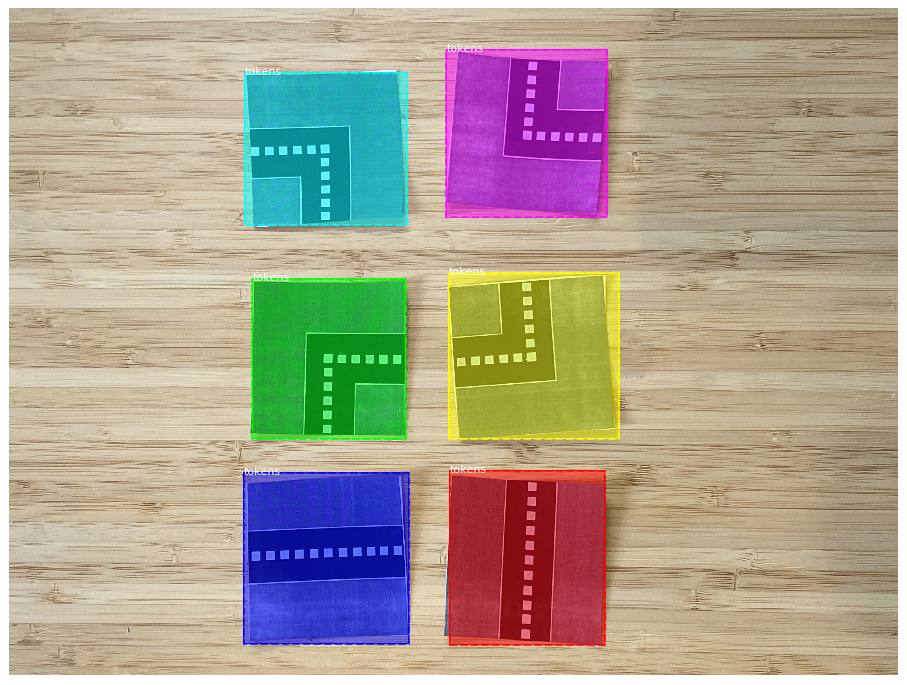

In [46]:
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances

# define image id
image_id = 1
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [47]:
%%writefile -a train.py

from mrcnn.config import Config

# define a configuration for the model
class ModelConfig(Config):
    # Give the configuration a recognizable name
    NAME = "token_recognition_cfg"
    # Number of classes (background + custom)
    NUM_CLASSES = 1 + 1
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 3
 
# prepare config
config = ModelConfig()

Appending to train.py


In [48]:
%%writefile -a train.py

from mrcnn.model import MaskRCNN

# define the model
model = MaskRCNN(mode='training', model_dir='./model/', config=config)

Appending to train.py


In [49]:
%%writefile -a train.py

# load weights (mscoco)
model.load_weights('pretrained_models/mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

Appending to train.py


In [50]:
%%writefile -a train.py

# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

Appending to train.py
